In [228]:
# Handige Jupyter magic
%config IPCompleter.greedy = True
%matplotlib inline

In [229]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [230]:
def remove_outliers(df,columns,n_std):
    for col in columns:        
        mean = df[col].mean()
        sd = df[col].std()
        
        df = df[(df[col] <= mean+(n_std*sd))]
        
    return df

In [231]:
# data uitlezen
def read_vektis_data(dir, start, end):
    dfArray = []

    for i in range(start, end):
        df = pd.read_csv(f'{dir}/vektis_20{i}.csv', sep=';', dtype={'geslacht': str, 'gemeentenaam': str, 'jaar': float}, low_memory=False)
        df.columns = df.columns.str.lower()
        df['jaar'] = 2000 + i
        dfArray.append(df)

    return pd.concat(dfArray)

# Read the data - data van voor 2015 mist veel GGZ data en is dus weggelaten
df = read_vektis_data('./Vektis', 15, 21)

# df = df[df['leeftijdsklasse'] != '90+']
# df = df.astype({'leeftijdsklasse': 'float'})

# Veel null waarden op kosten_eerstelijnsverblijf, dus die kolom droppen
df = df.drop(columns=['kosten_eerstelijnsverblijf'])

# if column kosten_gzsp is not null then concat kosten_gzsp and kosten_overig into kosten_overig
df['kosten_overig'] = df.apply(lambda row: row['kosten_gzsp'] if pd.notnull(row['kosten_gzsp']) else row['kosten_overig'], axis=1)
df = df.drop(columns=['kosten_gzsp', 'aantal_verzekerdejaren']).dropna()

# Loop through columns with prefix kosten_ and divide by aantal_bsn
# for column in df.columns:
#     if column.startswith('kosten_'):
#         df[column] = df[column] / df['aantal_bsn']


# df = df.drop(columns=['aantal_bsn'])
df = remove_outliers(df, ['kosten_huisarts_consult'], 3) # verwijder outliers met een 3 standaard deviaties

df.info()
df.head()
df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79311 entries, 1 to 13061
Data columns (total 27 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   geslacht                                79311 non-null  object 
 1   leeftijdsklasse                         79311 non-null  object 
 2   gemeentenaam                            79311 non-null  object 
 3   aantal_bsn                              79311 non-null  int64  
 4   kosten_medisch_specialistische_zorg     79311 non-null  float64
 5   kosten_farmacie                         79311 non-null  float64
 6   kosten_specialistische_ggz              79311 non-null  float64
 7   kosten_huisarts_inschrijftarief         79311 non-null  float64
 8   kosten_huisarts_consult                 79311 non-null  float64
 9   kosten_huisarts_mdz                     79311 non-null  float64
 10  kosten_huisarts_overig                  79311 non-null  fl

,geslacht,leeftijdsklasse,gemeentenaam,aantal_bsn,kosten_medisch_specialistische_zorg,kosten_farmacie,kosten_specialistische_ggz,kosten_huisarts_inschrijftarief,kosten_huisarts_consult,kosten_huisarts_mdz,...,kosten_kraamzorg,kosten_verloskundige_zorg,kosten_generalistische_basis_ggz,kosten_langdurige_ggz,kosten_grensoverschrijdende_zorg,kosten_eerstelijns_ondersteuning,kosten_geriatrische_revalidatiezorg,kosten_verpleging_en_verzorging,kosten_overig,jaar
1,M,0 t/m 4 jaar,AA EN HUNZE,515,737763.34,49488.17,0.00,26223.87,13459.45,411.19,...,0.0,0.0,0.0,0.0,375.97,28.35,0.00,0.00,113.35,2015
2,M,0 t/m 4 jaar,AALSMEER,852,705384.63,63242.65,0.00,43243.73,23420.48,1547.00,...,0.0,0.0,0.0,0.0,2326.77,12.15,0.00,0.00,22462.68,2015
3,M,0 t/m 4 jaar,AALTEN,647,1103685.08,66083.53,0.00,32981.00,17793.60,564.14,...,0.0,0.0,0.0,0.0,1558.91,5.40,0.00,417.52,3998.20,2015
4,M,0 t/m 4 jaar,ACHTKARSPELEN,769,621523.88,63226.38,0.00,39241.56,20205.64,82.28,...,0.0,0.0,0.0,0.0,2598.23,836.10,0.00,144.72,71566.02,2015
5,M,0 t/m 4 jaar,ALBLASSERDAM,627,1990449.43,95121.54,0.00,31543.70,17118.58,53.51,...,0.0,0.0,0.0,0.0,2113.16,5.85,0.00,266074.12,24623.79,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13057,V,90+,ZUNDERT,160,317749.39,131413.14,0.00,21855.38,19785.52,20183.62,...,0.0,0.0,0.0,0.0,841.79,0.00,81077.35,557199.58,128.70,2020
13058,V,90+,ZUTPHEN,360,602138.63,287938.12,2700.93,53046.10,81131.49,16613.75,...,0.0,0.0,0.0,0.0,0.00,0.00,150371.34,1928702.85,834.84,2020
13059,V,90+,ZWARTEWATERLAND,113,164053.26,99126.83,0.00,14463.88,37885.68,14045.59,...,0.0,0.0,0.0,0.0,0.00,0.00,102399.26,333372.66,269.77,2020
13060,V,90+,ZWIJNDRECHT,386,950541.19,313024.87,684.21,47564.17,72516.10,34260.94,...,0.0,0.0,0.0,0.0,0.00,0.00,357176.30,1739264.88,2235.59,2020


In [232]:
df['geslacht'].replace(['M', 'V'], [0, 1], inplace=True)

In [233]:
# loop through rows and round leeftijdsklasse to highest number in string "0 t/m 4 jaar" -> 4 except if it's 90+ then it's 90, use a for loop
for index, row in df.iterrows():
    if row['leeftijdsklasse'] == '90+':
        df.at[index, 'leeftijdsklasse'] = 90
    else:
        leeftijdArray = row['leeftijdsklasse'].strip().split(' ')
        
        # get the last number in leeftijdArray
        row['leeftijdsklasse'] = df.at[index, 'leeftijdsklasse'] = leeftijdArray[-1]

        if (row['leeftijdsklasse'] == 'jaar'):
             row['leeftijdsklasse'] = df.at[index, 'leeftijdsklasse'] = leeftijdArray[-2]

df.astype({'leeftijdsklasse': 'int32'}).dtypes
df

,geslacht,leeftijdsklasse,gemeentenaam,aantal_bsn,kosten_medisch_specialistische_zorg,kosten_farmacie,kosten_specialistische_ggz,kosten_huisarts_inschrijftarief,kosten_huisarts_consult,kosten_huisarts_mdz,...,kosten_kraamzorg,kosten_verloskundige_zorg,kosten_generalistische_basis_ggz,kosten_langdurige_ggz,kosten_grensoverschrijdende_zorg,kosten_eerstelijns_ondersteuning,kosten_geriatrische_revalidatiezorg,kosten_verpleging_en_verzorging,kosten_overig,jaar
1,0,4,AA EN HUNZE,515,737763.34,49488.17,0.00,26223.87,13459.45,411.19,...,0.0,0.0,0.0,0.0,375.97,28.35,0.00,0.00,113.35,2015
2,0,4,AALSMEER,852,705384.63,63242.65,0.00,43243.73,23420.48,1547.00,...,0.0,0.0,0.0,0.0,2326.77,12.15,0.00,0.00,22462.68,2015
3,0,4,AALTEN,647,1103685.08,66083.53,0.00,32981.00,17793.60,564.14,...,0.0,0.0,0.0,0.0,1558.91,5.40,0.00,417.52,3998.20,2015
4,0,4,ACHTKARSPELEN,769,621523.88,63226.38,0.00,39241.56,20205.64,82.28,...,0.0,0.0,0.0,0.0,2598.23,836.10,0.00,144.72,71566.02,2015
5,0,4,ALBLASSERDAM,627,1990449.43,95121.54,0.00,31543.70,17118.58,53.51,...,0.0,0.0,0.0,0.0,2113.16,5.85,0.00,266074.12,24623.79,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13057,1,90,ZUNDERT,160,317749.39,131413.14,0.00,21855.38,19785.52,20183.62,...,0.0,0.0,0.0,0.0,841.79,0.00,81077.35,557199.58,128.70,2020
13058,1,90,ZUTPHEN,360,602138.63,287938.12,2700.93,53046.10,81131.49,16613.75,...,0.0,0.0,0.0,0.0,0.00,0.00,150371.34,1928702.85,834.84,2020
13059,1,90,ZWARTEWATERLAND,113,164053.26,99126.83,0.00,14463.88,37885.68,14045.59,...,0.0,0.0,0.0,0.0,0.00,0.00,102399.26,333372.66,269.77,2020
13060,1,90,ZWIJNDRECHT,386,950541.19,313024.87,684.21,47564.17,72516.10,34260.94,...,0.0,0.0,0.0,0.0,0.00,0.00,357176.30,1739264.88,2235.59,2020


In [234]:
# only gemeenten ZWOLLE
df = df[df['gemeentenaam'] == 'DEVENTER']

In [236]:
df

,geslacht,leeftijdsklasse,gemeentenaam,aantal_bsn,kosten_medisch_specialistische_zorg,kosten_farmacie,kosten_specialistische_ggz,kosten_huisarts_inschrijftarief,kosten_huisarts_consult,kosten_huisarts_mdz,...,kosten_kraamzorg,kosten_verloskundige_zorg,kosten_generalistische_basis_ggz,kosten_langdurige_ggz,kosten_grensoverschrijdende_zorg,kosten_eerstelijns_ondersteuning,kosten_geriatrische_revalidatiezorg,kosten_verpleging_en_verzorging,kosten_overig,jaar
74,0,4,DEVENTER,2657,2935832.44,239008.77,0.00,136292.45,66829.48,269.11,...,0.0,0.0,0.00,0.00,10988.51,74.25,0.00,73626.19,378480.47,2015
429,0,9,DEVENTER,2929,898062.49,148360.68,0.00,171550.06,50211.80,362.94,...,0.0,0.0,0.00,0.00,2105.72,107.55,0.00,20201.88,15653.10,2015
784,0,14,DEVENTER,3100,972711.04,212062.80,0.00,181709.52,45606.19,1196.51,...,0.0,0.0,0.00,0.00,6112.13,104.40,0.00,18794.53,12124.02,2015
1139,0,19,DEVENTER,2997,1589886.03,215701.68,474084.09,175248.81,47222.11,11086.18,...,0.0,0.0,7017.96,205521.05,6878.24,63.00,0.00,14796.96,29577.96,2015
1494,0,24,DEVENTER,2717,1234028.66,211673.60,1033098.84,153392.67,46179.64,16827.70,...,0.0,0.0,67705.69,146788.40,5287.34,63.45,0.00,21048.50,3947.26,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11413,1,74,DEVENTER,2765,6863191.30,1653592.84,260355.57,218219.09,169754.54,344442.55,...,0.0,0.0,22573.76,326598.46,47626.97,0.00,310308.29,1066347.42,1690.99,2020
11757,1,79,DEVENTER,1793,5824918.40,1214988.51,315178.42,194326.94,147320.34,244689.79,...,0.0,0.0,12117.72,221883.00,18621.25,0.00,542923.55,1199340.03,2740.86,2020
12101,1,84,DEVENTER,1480,4651725.66,1176508.78,240841.47,164565.33,149456.39,225251.50,...,0.0,0.0,13577.51,59803.76,13891.96,0.00,564183.81,2143643.52,1506.60,2020
12445,1,89,DEVENTER,993,2787577.88,902489.91,117548.05,152789.90,134970.31,137361.06,...,0.0,0.0,9595.91,137012.10,9542.24,0.00,469149.56,2639014.00,4711.67,2020


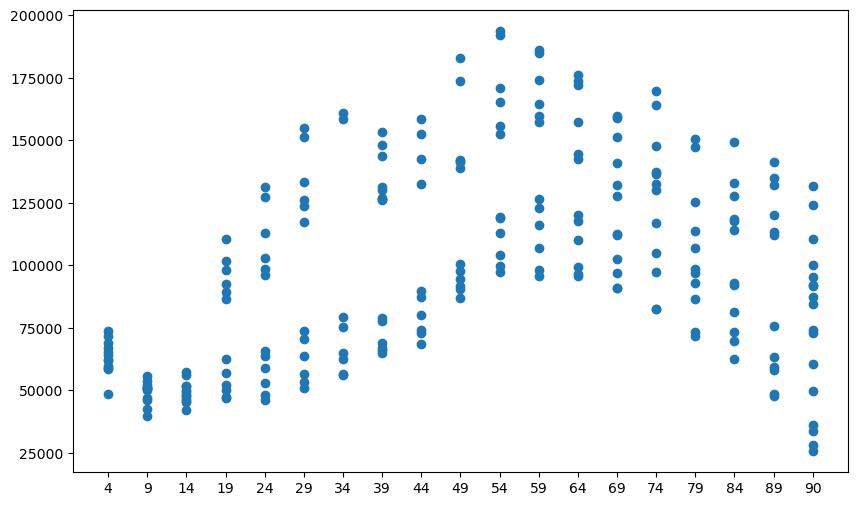

In [237]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

da = df.astype({'leeftijdsklasse': 'string'})

x = da['leeftijdsklasse']
y = da['kosten_huisarts_consult']

plt.figure(figsize=(10,6))
plt.scatter(x, y)
plt.show()

C:\Users\nickv\AppData\Local\Temp\ipykernel_27492\130386868.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dg = df.groupby(['jaar', 'leeftijdsklasse']).mean().reset_index()


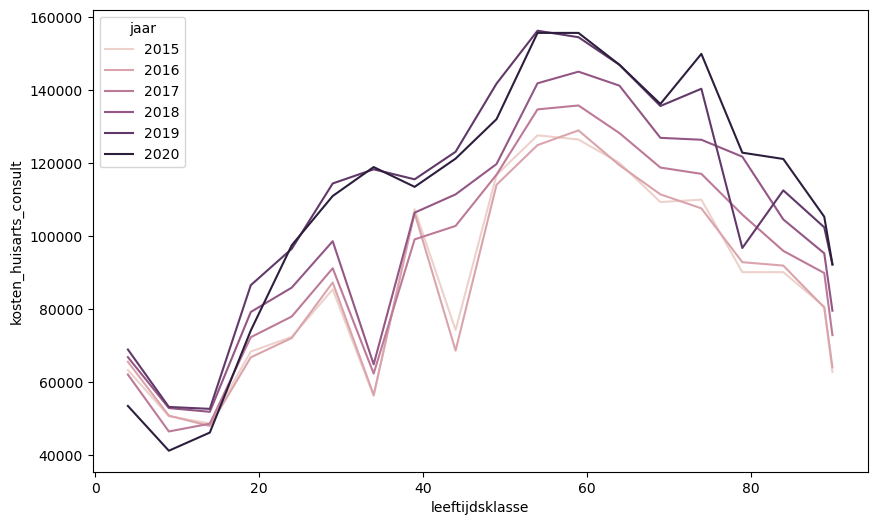

In [238]:
# get the mean kosten_farmacie per leeftijdsklasse per jaar
dg = df.groupby(['jaar', 'leeftijdsklasse']).mean().reset_index()

# plot the mean kosten_farmacie per leeftijdsklasse per jaar
plt.figure(figsize=(10,6))
sns.lineplot(x='leeftijdsklasse', y='kosten_huisarts_consult', hue='jaar', data=dg)
plt.show()

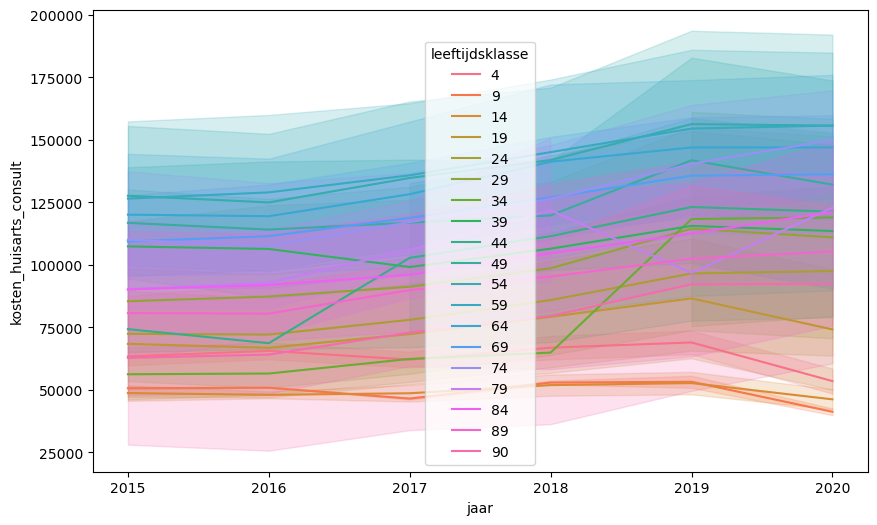

In [239]:
# plot the differences between postcodes
plt.figure(figsize=(10,6))
dp = df
sns.lineplot(x='jaar', y='kosten_huisarts_consult', hue='leeftijdsklasse', data=dp)
plt.show()

In [240]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# independent variable
X = np.concatenate((np.array(df['jaar']).reshape(-1, 1), np.array(df['leeftijdsklasse']).reshape(-1, 1)), axis=1)

# dependent variable
y = df['kosten_huisarts_consult']

# Create polynomial features
poly_features = PolynomialFeatures(degree=2)  # You can adjust the degree as per your requirement
X_poly = poly_features.fit_transform(X)

# Create an instance of the LinearRegression model
model = LinearRegression()

# Fit the model to the polynomial features
model.fit(X_poly, y)

# Predict the cost for new data
new_data_poly = poly_features.transform(X)
predicted_costs = model.predict(new_data_poly)

# get the actual kosten_generalistische_basis_ggz 
actual_costs = np.array(df['kosten_huisarts_consult'].values).reshape(-1, 1)

# Print the predicted costs
for i in range(len(predicted_costs)):
    print(f"Data point {i+1}:")
    print(f"Predicted cost: {predicted_costs[i]}")
    print(f"Actual cost: {actual_costs[i]}")
    print("---")

Data point 1:
Predicted cost: 31849.51867032051
Actual cost: [66829.48]
---
Data point 2:
Predicted cost: 46948.514211297035
Actual cost: [50211.8]
---
Data point 3:
Predicted cost: 60461.222385287285
Actual cost: [45606.19]
---
Data point 4:
Predicted cost: 72387.643191576
Actual cost: [47222.11]
---
Data point 5:
Predicted cost: 82727.7766302824
Actual cost: [46179.64]
---
Data point 6:
Predicted cost: 91481.62270116806
Actual cost: [53472.23]
---
Data point 7:
Predicted cost: 98649.18140482903
Actual cost: [56225.44]
---
Data point 8:
Predicted cost: 104230.45274055004
Actual cost: [65106.11]
---
Data point 9:
Predicted cost: 108225.43670892715
Actual cost: [74269.21]
---
Data point 10:
Predicted cost: 110634.13330984116
Actual cost: [94523.67]
---
Data point 11:
Predicted cost: 111456.54254305363
Actual cost: [99683.94]
---
Data point 12:
Predicted cost: 110692.66440844536
Actual cost: [95586.05]
---
Data point 13:
Predicted cost: 108342.49890625477
Actual cost: [95722.45]
---
Data

In [241]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error

# Calculate R-squared score
r2 = r2_score(actual_costs, predicted_costs)
print(f"R-squared: {r2}")

R-squared: 0.45124249992596344


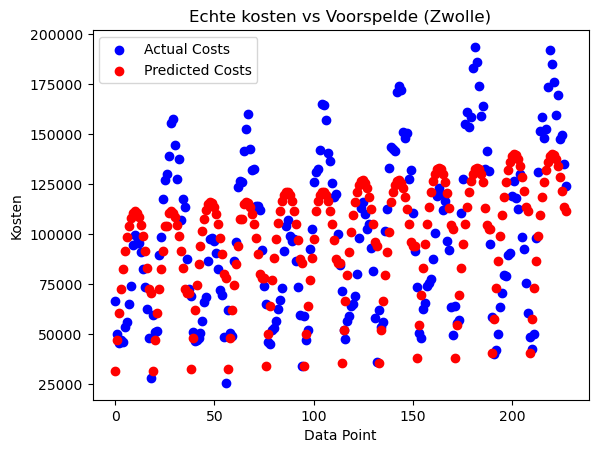

In [242]:
plt.scatter(range(len(actual_costs)), actual_costs, color='blue', label='Actual Costs')
plt.scatter(range(len(predicted_costs)), predicted_costs, color='red', label='Predicted Costs')

plt.xlabel('Data Point')
plt.ylabel('Kosten')
plt.title('Echte kosten vs Voorspelde (Zwolle)')
plt.legend()
plt.show()

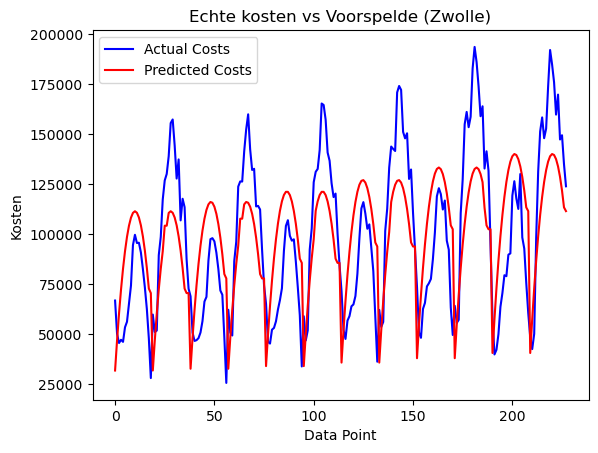

In [243]:
import matplotlib.pyplot as plt

x_values = range(len(actual_costs))

plt.plot(x_values, actual_costs, color='blue', label='Actual Costs')
plt.plot(x_values, predicted_costs, color='red', label='Predicted Costs')

plt.xlabel('Data Point')
plt.ylabel('Kosten')
plt.title('Echte kosten vs Voorspelde (Zwolle)')
plt.legend()
plt.show()

In [254]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# independent variable
X = np.concatenate((np.array(df['jaar']).reshape(-1, 1), np.array(df['leeftijdsklasse']).reshape(-1, 1), np.array(df['geslacht']).reshape(-1, 1)), axis=1)

# dependent variable
y = df['kosten_huisarts_consult']

# Create polynomial features
poly_features = PolynomialFeatures(degree=2)  # You can adjust the degree as per your requirement
X_poly = poly_features.fit_transform(X)

# Create an instance of the LinearRegression model
model = LinearRegression()

# Fit the model to the polynomial features
model.fit(X_poly, y)

# Predict the cost for new data
new_data_poly = poly_features.transform(X)
predicted_costs = model.predict(new_data_poly)

# get the actual kosten_generalistische_basis_ggz 
actual_costs = np.array(y.values)

# Print the predicted costs
for i in range(len(predicted_costs)):
    print(f"Data point {i+1}:")
    print(f"Predicted cost: {predicted_costs[i]}")
    print(f"Actual cost: {actual_costs[i]}")
    print("---")

Data point 1:
Predicted cost: 19191.349908590317
Actual cost: [66829.48]
---
Data point 2:
Predicted cost: 33870.77642440796
Actual cost: [50211.8]
---
Data point 3:
Predicted cost: 46865.488931536674
Actual cost: [45606.19]
---
Data point 4:
Predicted cost: 58175.487429857254
Actual cost: [47222.11]
---
Data point 5:
Predicted cost: 67800.77191972733
Actual cost: [46179.64]
---
Data point 6:
Predicted cost: 75741.34240090847
Actual cost: [53472.23]
---
Data point 7:
Predicted cost: 81997.19887340069
Actual cost: [56225.44]
---
Data point 8:
Predicted cost: 86568.34133720398
Actual cost: [65106.11]
---
Data point 9:
Predicted cost: 89454.76979231834
Actual cost: [74269.21]
---
Data point 10:
Predicted cost: 90656.48423850536
Actual cost: [94523.67]
---
Data point 11:
Predicted cost: 90173.48467636108
Actual cost: [99683.94]
---
Data point 12:
Predicted cost: 88005.77110540867
Actual cost: [95586.05]
---
Data point 13:
Predicted cost: 84153.34352588654
Actual cost: [95722.45]
---
Data p

In [245]:
from sklearn.metrics import r2_score

# Calculate R-squared score
r2 = r2_score(actual_costs, predicted_costs)
print(f"R-squared: {r2}")

R-squared: 0.8285111859439733


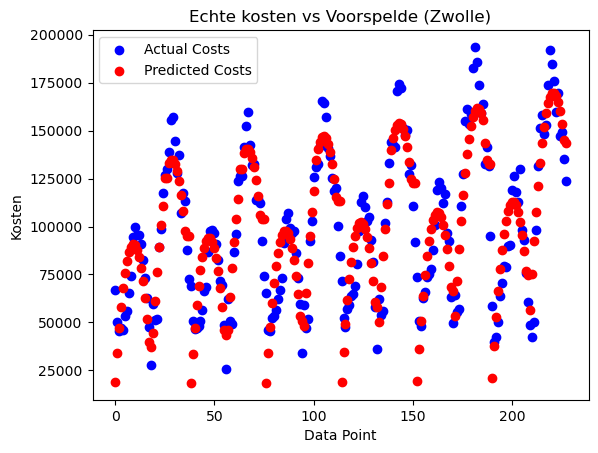

In [246]:
plt.scatter(range(len(actual_costs)), actual_costs, color='blue', label='Actual Costs')
plt.scatter(range(len(predicted_costs)), predicted_costs, color='red', label='Predicted Costs')

plt.xlabel('Data Point')
plt.ylabel('Kosten')
plt.title('Echte kosten vs Voorspelde (Deventer)')
plt.legend()
plt.show()

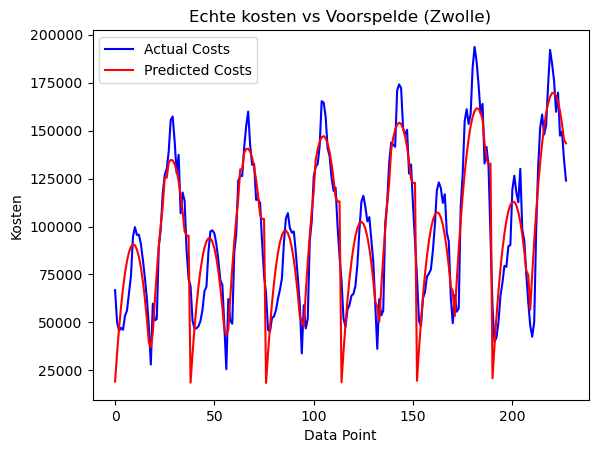

In [247]:
import matplotlib.pyplot as plt

x_values = range(len(actual_costs))

plt.plot(x_values, actual_costs, color='blue', label='Actual Costs')
plt.plot(x_values, predicted_costs, color='red', label='Predicted Costs')

plt.xlabel('Data Point')
plt.ylabel('Kosten')
plt.title('Echte kosten vs Voorspelde (Deventer)')
plt.legend()
plt.show()


In [248]:
caseLeeftijd = np.array([24]).reshape(-1, 1) #24 jaar
caseJaar = np.array([2015]).reshape(-1, 1) #2015
caseGender= np.array([0]).reshape(-1, 1) #man

# Predict the cost for new data
new_data = np.concatenate((caseJaar, caseLeeftijd, caseGender), axis=1)
new_data_poly = poly_features.transform(new_data)
predicted_costs = model.predict(new_data_poly)

# get the actual kosten_generalistische_basis_ggz 
actual_costs = np.array(df['kosten_huisarts_consult'].values).reshape(-1, 1)

# Print the predicted costs
for i in range(len(predicted_costs)):
    print(f"Data point {i+1}:")
    print(f"Predicted cost: {predicted_costs[i]}")
    print(f"Actual cost: {actual_costs[i]}")
    print("---")

Data point 1:
Predicted cost: 67800.77191972733
Actual cost: [66829.48]
---


In [252]:
jaren = np.arange(2015,2030,1)
geslacht = [0]
leeftijd = [24]

def predictCost(leeftijd, jaar, geslacht):
    leeftijdArray = np.array([leeftijd]).reshape(-1, 1)
    jaarArray = np.array([jaar]).reshape(-1, 1)
    geslachtArray= np.array([geslacht]).reshape(-1, 1)

    new_data = np.concatenate((jaarArray, leeftijdArray, geslachtArray), axis=1)
    new_data_poly = poly_features.transform(new_data)
    predicted_costs = model.predict(new_data_poly)

    return predicted_costs[0]

def actual_cost_list(leeftijdsklasse, jaar, geslacht, column):
    filtered_df = df[(df['leeftijdsklasse'] == leeftijdsklasse) & (df['jaar'] == jaar) & (df['geslacht'] == geslacht)]

    if (filtered_df.empty):
        return None

    kosten_huisarts_consult = filtered_df[column].values
    return kosten_huisarts_consult[0]

predicted_costs_list = [predictCost(leeftijd, jaar, geslacht) for jaar in jaren]
print(predicted_costs_list)

actual_costs_list = [actual_cost_list(str(leeftijd[0]), jaar, geslacht[0], 'kosten_huisarts_consult') for jaar in jaren]
print(actual_costs_list)

[67800.77191972733, 68899.6317344904, 70459.68922281265, 72480.94438445568, 74963.39721953869, 77907.04772806168, 81311.89591002464, 85177.94176530838, 89505.1852941513, 94293.62649643421, 99543.2653722763, 105254.10192167759, 111426.13614428043, 118059.36804044247, 125153.79760968685]
[46179.64, 48030.27, 53146.83, 59025.09, 65653.05, 63682.22, None, None, None, None, None, None, None, None, None]


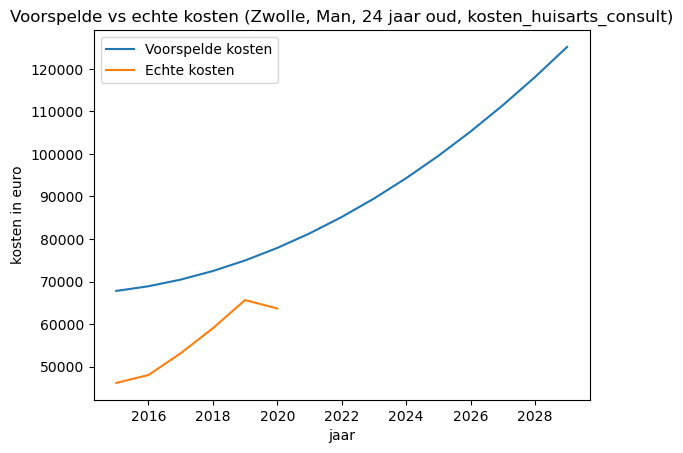

In [253]:
# Plotting the line chart
plt.plot(jaren, predicted_costs_list, label='Voorspelde kosten')
plt.plot(jaren, actual_costs_list, label='Echte kosten')

# Adding labels and title
plt.xlabel('jaar')
plt.ylabel('kosten in euro')
plt.title('Voorspelde vs echte kosten (Zwolle, Man, 24 jaar oud, kosten_huisarts_consult)')

# Adding a legend
plt.legend()

# Displaying the plot
plt.show()


In [251]:
import statsmodels.formula.api as smf

# fitting the model
smodel = smf.ols(formula='kosten_huisarts_consult ~ leeftijdsklasse + jaar + geslacht',
                data=df).fit()
  
# model summary
print(smodel.summary())

                               OLS Regression Results                              
Dep. Variable:     kosten_huisarts_consult   R-squared:                       0.886
Model:                                 OLS   Adj. R-squared:                  0.875
Method:                      Least Squares   F-statistic:                     80.40
Date:                     Fri, 09 Jun 2023   Prob (F-statistic):           5.02e-86
Time:                             16:52:01   Log-Likelihood:                -2492.3
No. Observations:                      228   AIC:                             5027.
Df Residuals:                          207   BIC:                             5099.
Df Model:                               20                                         
Covariance Type:                 nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------